# RSCV Model building

### Import Modules

In [1]:
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict

from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error

from scipy.stats import randint

In [2]:
print(np.__version__)

2.0.0


In [3]:
import sklearn

sklearn.show_versions()


System:
    python: 3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:23:07) [GCC 12.3.0]
executable: /home/fhwn.ac.at/202375/.conda/envs/thesis/bin/python
   machine: Linux-5.15.0-101-generic-x86_64-with-glibc2.31

Python dependencies:
      sklearn: 1.5.0
          pip: 24.0
   setuptools: 70.0.0
        numpy: 2.0.0
        scipy: 1.13.1
       Cython: None
       pandas: 2.2.2
   matplotlib: 3.8.4
       joblib: 1.4.2
threadpoolctl: 3.5.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
    num_threads: 80
         prefix: libopenblas
       filepath: /home/fhwn.ac.at/202375/.conda/envs/thesis/lib/libopenblasp-r0.3.27.so
        version: 0.3.27
threading_layer: pthreads
   architecture: SkylakeX

       user_api: openmp
   internal_api: openmp
    num_threads: 80
         prefix: libgomp
       filepath: /home/fhwn.ac.at/202375/.conda/envs/thesis/lib/libgomp.so.1.0.0
        version: None


### Define Paths

In [4]:
# sys.path.clear()

# Basepath
basepath = "../"  # Project directory
sys.path.append(basepath)

# Data
DATA_PATH = basepath + "data"

# Results path
RESULTS_PATH = basepath + "03_Modelling/03_1_rscv/rscv_results/"

# Figure path
FIGURE_PATH = basepath + "03_Modelling/03_1_rscv/rscv_figures/"

# Path to environment
ENV_PATH = "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib"

# Modelpath
MODEL_PATH = basepath + "models"

# Logging
LOG_DIR = basepath + "03_Modelling/03_1_rscv/"

# Active Learning library
AL_PATH = basepath + "al_lib"

# Add the paths
sys.path.extend(
    {DATA_PATH, FIGURE_PATH, ENV_PATH, MODEL_PATH, RESULTS_PATH, LOG_DIR, AL_PATH}
)
sys.path  # Check if the path is correct

['/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python312.zip',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/lib-dynload',
 '',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages',
 '../',
 '../03_Modelling/03_1_rscv/rscv_results/',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib',
 '../models',
 '../03_Modelling/03_1_rscv/rscv_figures/',
 '../al_lib',
 '../data',
 '../03_Modelling/03_1_rscv/']

### Logging

In [5]:
LOG_DIR

'../03_Modelling/03_1_rscv/'

In [6]:
# import the logging specifications from file 'logging_config.py'
from al_lib.logging_config import create_logger
import datetime

# Add data/time information
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")

# Define the notebook name and the output name
notebook_name = "03_1_rscv.ipynb"  # Is also used when saving the notebook
output_name = f"{notebook_name.split('.')[0]}_{date}.html"

# Specify logging location
log_file_name = f"{notebook_name.split('.')[0]}_{date}.log"
log_file_dir = f"{LOG_DIR}"
log_file_path = f"{LOG_DIR}/{log_file_name}"
# print(f"Log file path: {log_file_path}")

# Get the logger
# logger = None
logging = create_logger(__name__, log_file_path=log_file_path)

# Usage of the logger as follows:
logging.info("Logging started")

2024-06-30 14:58:29 - INFO - Logging started


### Import Data

## Import dpsDeriv1200.csv

In [7]:
data_dps_deriv_1200 = pd.read_csv(
    DATA_PATH + "/dpsDeriv1200.csv", sep=",", decimal=".", encoding="utf-8"
)
data_dps_deriv_1200 = data_dps_deriv_1200.rename(columns=lambda x: x.replace("X", ""))
data_dps_deriv_1200 = data_dps_deriv_1200.rename(columns={"Unnamed: 0": "Samplename"})
data_dps_deriv_1200

Samplename  year      tree Origin    type          2970  \
0      2GOS-18_1955  1955   2GOS-18    POL  living -7.236150e-08   
1      2GOS-18_1969  1969   2GOS-18    POL  living  1.739940e-05   
2      2GOS-18_1974  1974   2GOS-18    POL  living  1.629130e-05   
3      2GOS-18_1976  1976   2GOS-18    POL  living  9.659060e-06   
4      2GOS-18_1996  1996   2GOS-18    POL  living  9.218540e-06   
...             ...   ...       ...    ...     ...           ...   
1285  SZLPS15a_1942  1942  SZLPS15a    AUT  living  1.930000e-06   
1286  SZLPS15a_1952  1952  SZLPS15a    AUT  living  1.410000e-06   
1287  SZLPS15a_1962  1962  SZLPS15a    AUT  living -1.980000e-06   
1288  SZLPS15a_1972  1972  SZLPS15a    AUT  living  3.140000e-06   
1289  SZLPS15a_1982  1982  SZLPS15a    AUT  living -7.300000e-07   

              2968      2966          2964          2962  ...           818  \
0     4.010600e-07  0.000005  1.310370e-05  1.788600e-05  ... -4.740000e-06   
1     4.649250e-06 -0.000007 -1.769050e-05 -2.597300e-05  ... -2.730000e-07   
2     1.129150e-05  0.000006  5.111420e-07 -5.256790e-06  ... -1.890000e-06   
3     4.122150e-06  0.000003  4.831610e-06  3.334600e-06  ... -1.630000e-06   
4     3.989240e-06 -0.000006 -1.145560e-05 -6.957740e-06  ...  2.350000e-07   
...            ...       ...           ...           ...  ...           ...   
1285 -1.740000e-06 -0.000005 -4.760000e-06  1.920000e-07  ... -9.250000e-06   
1286 -4.960000e-06 -0.000010 -6.870000e-06  2.740000e-06  ... -5.970000e-06   
1287 -3.530000e-06 -0.000002  3.120000e-06  9.860000e-06  ... -6.480000e-06   
1288 -5.210000e-06 -0.000011 -9.600000e-06 -1.490000e-06  ... -1.120000e-06   
1289 -5.030000e-06 -0.000007 -4.280000e-06  3.350000e-06  ... -5.560000e-06   

           816       814       812       810       808       806       804  \
0    -0.000020 -0.000034 -0.000045 -0.000052 -0.000054 -0.000049 -0.000038   
1    -0.000016 -0.000031 -0.000042 -0.000046 -0.000045 -0.000040 -0.000031   
2    -0.000014 -0.000025 -0.000036 -0.000043 -0.000046 -0.000043 -0.000035   
3    -0.000016 -0.000030 -0.000043 -0.000052 -0.000055 -0.000051 -0.000040   
4    -0.000010 -0.000023 -0.000037 -0.000047 -0.000052 -0.000050 -0.000044   
...        ...       ...       ...       ...       ...       ...       ...   
1285 -0.000026 -0.000041 -0.000054 -0.000063 -0.000064 -0.000059 -0.000047   
1286 -0.000025 -0.000042 -0.000056 -0.000063 -0.000064 -0.000058 -0.000046   
1287 -0.000026 -0.000044 -0.000058 -0.000065 -0.000064 -0.000055 -0.000042   
1288 -0.000020 -0.000038 -0.000055 -0.000066 -0.000069 -0.000064 -0.000052   
1289 -0.000024 -0.000041 -0.000054 -0.000062 -0.000064 -0.000058 -0.000048   

           802       800  
0    -0.000023 -0.000011  
1    -0.000019 -0.000007  
2    -0.000023 -0.000013  
3    -0.000025 -0.000012  
4    -0.000035 -0.000023  
...        ...       ...  
1285 -0.000032 -0.000016  
1286 -0.000030 -0.000015  
1287 -0.000027 -0.000013  
1288 -0.000036 -0.000020  
1289 -0.000033 -0.000017  

[1290 rows x 415 columns]

## Select Data

In [8]:
# Switch for the dataset
# Select from (data_small, data_full, data_2nd_deriv) or other if implemented
data_raw = data_dps_deriv_1200
data_raw.dataset_name = "data_dps_deriv_1200"
logging.info(f"Dataset: {data_raw.dataset_name}")
logging.info(f"Size of the dataset: {data_raw.shape}")

2024-06-30 14:58:30 - INFO - Dataset: data_dps_deriv_1200
2024-06-30 14:58:30 - INFO - Size of the dataset: (1290, 415)


## Modelling Parameters

In [9]:
# Define the parameters for the CV

# Switch for testing mode (use only 10% of the data, among others)
testing = False

# Define a random state for randomized processes
random_state = np.random.RandomState(202375)

if testing == True:
    nfolds = 5
    NoTrials = 5
    n_jobs = 20
    save_model = False
    # data = data_raw.sample(frac=0.15, random_state=random_state)
    data = data_raw
    logging.info(f"Size of the dataset reduced: {data.shape}")
else:
    nfolds = 10
    NoTrials = 15
    n_jobs = 30
    save_model = True
    data = data_raw
    logging.info(f"Size of the dataset not reduced: {data.shape}")

# Log the modelling parameters
logging.info(
    f"Testing for Cross Validation: {testing}, nfolds: {nfolds}, NoTrials: {NoTrials}, n_jobs: {n_jobs}"
)


2024-06-30 14:58:30 - INFO - Size of the dataset not reduced: (1290, 415)
2024-06-30 14:58:30 - INFO - Testing for Cross Validation: False, nfolds: 10, NoTrials: 15, n_jobs: 30


## Sklearn Warnings

During testing, some warnings are not relevant, and to simplify the output results warning filter can be cosntructed in sklearn. 

In [10]:
from warnings import simplefilter
import warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import FitFailedWarning

# Turn of sklearn warnings for failed fits 
if testing == True: 
    simplefilter("ignore", category=FitFailedWarning)
    simplefilter("ignore", category=ConvergenceWarning)
    warnings.filterwarnings(
    "ignore", message=".*y residual is constant*.", category=UserWarning, append=False
    )

## Preprocessing

To apply the models we need to split the data into the variables and target.

In [11]:
data.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

In [12]:
data.dtypes.value_counts()

float64    410
object       4
int64        1
Name: count, dtype: int64

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290 entries, 0 to 1289
Columns: 415 entries, Samplename to 800
dtypes: float64(410), int64(1), object(4)
memory usage: 4.1+ MB


In [14]:
data.describe()

year         2970         2968          2966         2964  \
count  1290.000000  1290.000000  1290.000000  1.290000e+03  1290.000000   
mean   1740.420930     0.000012     0.000005 -9.431341e-07    -0.000005   
std     196.420289     0.000014     0.000012  1.202741e-05     0.000013   
min    1194.000000    -0.000027    -0.000039 -1.000000e-04    -0.000149   
25%    1616.000000     0.000004    -0.000002 -7.924335e-06    -0.000011   
50%    1769.000000     0.000011     0.000005 -2.170000e-07    -0.000003   
75%    1913.000000     0.000019     0.000012  6.660000e-06     0.000004   
max    2009.000000     0.000116     0.000086  4.120000e-05     0.000025   

              2962          2960         2959         2957         2955  ...  \
count  1290.000000  1.290000e+03  1290.000000  1290.000000  1290.000000  ...   
mean     -0.000006 -4.172513e-06     0.000001     0.000009     0.000017  ...   
std       0.000017  1.994992e-05     0.000022     0.000022     0.000019  ...   
min      -0.000182 -1.940000e-04    -0.000183    -0.000191    -0.000163  ...   
25%      -0.000012 -1.076210e-05    -0.000006     0.000002     0.000010  ...   
50%      -0.000003 -2.638125e-07     0.000005     0.000013     0.000020  ...   
75%       0.000004  7.850000e-06     0.000014     0.000022     0.000028  ...   
max       0.000030  3.550000e-05     0.000046     0.000053     0.000063  ...   

               818          816          814          812          810  \
count  1290.000000  1290.000000  1290.000000  1290.000000  1290.000000   
mean     -0.000008    -0.000028    -0.000045    -0.000057    -0.000061   
std       0.000010     0.000012     0.000013     0.000014     0.000013   
min      -0.000040    -0.000060    -0.000082    -0.000099    -0.000110   
25%      -0.000016    -0.000036    -0.000055    -0.000066    -0.000069   
50%      -0.000009    -0.000028    -0.000045    -0.000057    -0.000062   
75%      -0.000001    -0.000019    -0.000035    -0.000047    -0.000053   
max       0.000023     0.000003    -0.000013    -0.000019    -0.000021   

               808          806          804          802          800  
count  1290.000000  1290.000000  1290.000000  1290.000000  1290.000000  
mean     -0.000059    -0.000050    -0.000038    -0.000023    -0.000009  
std       0.000011     0.000010     0.000009     0.000008     0.000007  
min      -0.000105    -0.000094    -0.000079    -0.000057    -0.000032  
25%      -0.000066    -0.000056    -0.000043    -0.000029    -0.000014  
50%      -0.000059    -0.000050    -0.000037    -0.000023    -0.000009  
75%      -0.000052    -0.000045    -0.000032    -0.000018    -0.000004  
max      -0.000021    -0.000016    -0.000009     0.000002     0.000013  

[8 rows x 411 columns]

In [15]:
# Split into target and features
# The goal is to predict the year column of the dataset using the spectral data
X = data.select_dtypes("float")
y = data["year"]
X.shape, y.shape

((1290, 410), (1290,))

In [16]:
# count the number of columns with std = 0.0 in X
logging.info(f"Number of columns dropped, where std = 0.0 in X: {(X.std() == 0.0).sum()}")

2024-06-30 14:58:42 - INFO - Number of columns dropped, where std = 0.0 in X: 0


In [17]:
# drop the columns with std = 0.0
X = X.loc[:, X.std() != 0.0]
X.shape, y.shape
logging.info(f"Dimensions of X after dropping columns with std = 0.0: {X.shape}")
logging.info(f"Dimensions of Y: {y.shape}")


2024-06-30 14:58:43 - INFO - Dimensions of X after dropping columns with std = 0.0: (1290, 410)
2024-06-30 14:58:43 - INFO - Dimensions of Y: (1290,)


In [18]:
# Split the data into training and test sets
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)
logging.info(f"random split with testsize {test_size} into training and test sets")


2024-06-30 14:58:45 - INFO - random split with testsize 0.3 into training and test sets


In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# assert the shapes and raise an error if they are not equal
assert X_train.shape[0] + X_test.shape[0] == X.shape[0]
assert y_train.shape[0] + y_test.shape[0] == y.shape[0]

## Define Score metrics

In [20]:
from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_error

# create a scorer which calculates Root Mean Squeared Error (RMSE)

scoring = make_scorer(root_mean_squared_error, greater_is_better=False)
# scoring = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
logging.info(f"Scorer: {scoring}")

2024-06-30 14:58:51 - INFO - Scorer: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')


# Modeling with Randomized Search Crossvalidation (RSCV)

#### Models

In [21]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.neural_network import MLPRegressor as MLP
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor as HGB
from sklearn.ensemble import RandomForestRegressor

## Hyperparameter Definition

Randomized Search CV is usefull for the efficient exploration of a large parameter space. The results can consequently be used to design a fine grid for the Grid Search CV

In [22]:
# load the Hyperparameter distributions for the RandomizedSearchCV
from al_lib.rscv_parameters import (
    rf_rscv_parameters,
    pls_rscv_parameters,
    krr_rscv_parameters,
    mlp_rscv_parameters,
    xgb_rscv_parameters,
    hgb_rscv_parameters,
)

# to update the import without restarting the kernel, uncoment and modify the following line
# del <model>_parameters

In [23]:
import pandas as pd
import numpy as np

models = {
    "rf": RandomForestRegressor(),
    "pls": PLSRegression(),
    "krr": KRR(),
    "mlp": MLP(),
    "xgb": XGBRegressor(),
    "hgb": HGB(),
}

# Prepare objects to store the results
# Template:
# rf_rscv_results = pd.DataFrame(columns=["model", "MAE", "RMSE", "params"])
for model in models.keys():
    globals()[f"{model}_rscv_results"] = pd.DataFrame(
        columns=["model", "MAE", "RMSE", "params"]
    )
    print(f"{model}_rscv_parameters")

rf_rscv_parameters
pls_rscv_parameters
krr_rscv_parameters
mlp_rscv_parameters
xgb_rscv_parameters
hgb_rscv_parameters


## Defining the rscv process

In [24]:
from al_lib.helper_functions import rmse_func as rmse
from al_lib.helper_functions import report_model
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.metrics import (
    mean_squared_error,
)  # also imports the neg_root_mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import make_scorer


# create a scorer which calculates Root Mean Squeared Error (RMSE)


def rscv(
    features,
    target,
    model,
    param_distributions,
    results_file,
    random_state,
    NoTrials=5,
    nfolds=4,
    n_jobs=5,
    scoring=scoring, #
):
    """_summary_

    Args:
        features (_type_): _description_
        target (_type_): _description_
        model (_type_): _description_
        param_distributions (_type_): _description_
        results_file (_type_): _description_
        random_state (_type_): _description_
        NoTrials (int, optional): _description_. Defaults to 5.
        nfolds (int, optional): _description_. Defaults to 4.
        n_jobs (int, optional): _description_. Defaults to 5.
        scoring (_type_, optional): _description_. Defaults to scoring.

    Returns:
        _type_: _description_
    """
    logging.info(f"STARTED the RandomizedSearchCV for {model} with {NoTrials} trials")
    # log the args
    logging.info(
        f"Features: {features.shape}, Target: {target.shape}, Model: {model}, Param_distributions: {param_distributions}, Results File: {results_file} Random_state: {random_state}, NoTrials: {NoTrials}, nfolds: {nfolds}, n_jobs: {n_jobs}, Scoring: {scoring}"
    )
    logging.info(f"Results file: {results_file}")

    # prepare the result object 1
    rscv_results = pd.DataFrame(columns=["model", "MAE", "RMSE", "params"])

    # define the train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.3, random_state=random_state
    )
    # create the result objects 2
    rscv_rmse_inner = np.zeros(NoTrials)
    rscv_rmse_outer = np.zeros(NoTrials)

    for i in range(NoTrials):
        logging.info(f"Trial: {i} out of {NoTrials}")
        # split for nested cross-validation
        inner_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)
        outer_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)

        # non-nested parameter search and scoring
        rscv = RandomizedSearchCV(
            model,
            param_distributions=param_distributions,
            n_iter=10,
            cv=inner_cv,
            random_state=random_state,
            scoring=scoring,

            n_jobs=n_jobs,
        )

        # fit
        rscv.fit(X_train, y_train)
        # make predictions to later estimate the generalization error
        y_pred = cvp(rscv, X_test, y_test, cv=outer_cv, n_jobs=n_jobs)
        all_predictions = np.zeros((len(y_test), NoTrials))
        all_predictions[:, i] = y_pred
        # calculate the RMSE for the inner and outer CV
        rscv_rmse_inner[i] = rscv.best_score_

        # calculate the RMSE for the outer CV
        # rscv_rmse_outer[i] = np.sqrt(mean_squared_error(y_test, y_pred))
        rscv_rmse_outer[i] = rmse(y_test, y_pred)
        # store the results
        rscv_results.loc[i, "model"] = rscv.estimator
        rscv_results.loc[i, "MAE"] = mean_absolute_error(y_test, y_pred)
        rscv_results.loc[i, "RMSE"] = np.sqrt(mean_squared_error(y_test, y_pred))
        rscv_results.at[i, "params"] = rscv.best_params_
        report_model(rscv)

    # write results into outputifle
    rscv_results.to_csv(results_file, index=False, mode="a")
    logging.info(f"FINISHED the RandomizedSearchCV for {model} with {NoTrials} trials")
    return rscv_results
    # the goal of the rscv is to find the optimal hyperparameters
    # for further investigation we want to store
    # the 10 best model parameters and their scores
    # both the inner and outer cv scores, as well as the score difference

# Random Forest Regressor - RSCV

In [102]:
rf = RandomForestRegressor()
rf_rscv_results_file = f"{RESULTS_PATH}rf_rscv_results.csv"

rscv(
    features=X,
    target=y,
    model=rf,
    param_distributions=rf_rscv_parameters,
    results_file=rf_rscv_results_file,
    random_state=random_state,
    NoTrials=NoTrials,
    nfolds=nfolds,
    n_jobs=n_jobs
)

2024-06-26 22:37:53 - INFO - STARTED the RandomizedSearchCV for RandomForestRegressor() with 15 trials
2024-06-26 22:37:53 - INFO - Features: (1290, 410), Target: (1290,), Model: RandomForestRegressor(), Param_distributions: {'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f733ea35220>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f733dbce1e0>, 'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f733dbcef30>, 'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f733dd4bc50>}, Results File: ../03_Modelling/03_1_rscv/rscv_results/rf_rscv_results.csv Random_state: RandomState(MT19937), NoTrials: 15, nfolds: 10, n_jobs: 30, Scoring: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')
2024-06-26 22:37:53 - INFO - Results file: ../03_Modelling/03_1_rscv/rscv_results/rf_rscv_results.csv
2024-06-26 22:37:53 - INFO - Trial: 

Best hyperparameters for RandomForestRegressor: {'max_depth': 12, 'max_features': 7, 'min_samples_split': 11, 'n_estimators': 53}
Best score -109.88364777882347 for RandomForestRegressor: -109.88364777882347
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=12, max_features=7, min_samples_split=11,
                      n_estimators=53)


2024-06-26 22:38:39 - INFO - Trial: 2 out of 15


Best hyperparameters for RandomForestRegressor: {'max_depth': 18, 'max_features': 7, 'min_samples_split': 2, 'n_estimators': 59}
Best score -108.93862670365343 for RandomForestRegressor: -108.93862670365343
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=18, max_features=7, n_estimators=59)


2024-06-26 22:38:55 - INFO - Trial: 3 out of 15


Best hyperparameters for RandomForestRegressor: {'max_depth': 11, 'max_features': 6, 'min_samples_split': 8, 'n_estimators': 68}
Best score -111.55725623669787 for RandomForestRegressor: -111.55725623669787
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=11, max_features=6, min_samples_split=8,
                      n_estimators=68)


2024-06-26 22:39:17 - INFO - Trial: 4 out of 15


Best hyperparameters for RandomForestRegressor: {'max_depth': 17, 'max_features': 5, 'min_samples_split': 10, 'n_estimators': 73}
Best score -114.50851427874227 for RandomForestRegressor: -114.50851427874227
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=17, max_features=5, min_samples_split=10,
                      n_estimators=73)


2024-06-26 22:39:38 - INFO - Trial: 5 out of 15


Best hyperparameters for RandomForestRegressor: {'max_depth': 19, 'max_features': 5, 'min_samples_split': 3, 'n_estimators': 73}
Best score -111.705251965546 for RandomForestRegressor: -111.705251965546
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=19, max_features=5, min_samples_split=3,
                      n_estimators=73)


2024-06-26 22:39:54 - INFO - Trial: 6 out of 15


Best hyperparameters for RandomForestRegressor: {'max_depth': 17, 'max_features': 6, 'min_samples_split': 9, 'n_estimators': 33}
Best score -113.6303573126185 for RandomForestRegressor: -113.6303573126185
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=17, max_features=6, min_samples_split=9,
                      n_estimators=33)


2024-06-26 22:40:11 - INFO - Trial: 7 out of 15


Best hyperparameters for RandomForestRegressor: {'max_depth': 14, 'max_features': 6, 'min_samples_split': 14, 'n_estimators': 79}
Best score -113.19079164955528 for RandomForestRegressor: -113.19079164955528
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=14, max_features=6, min_samples_split=14,
                      n_estimators=79)


2024-06-26 22:40:36 - INFO - Trial: 8 out of 15


Best hyperparameters for RandomForestRegressor: {'max_depth': 7, 'max_features': 6, 'min_samples_split': 8, 'n_estimators': 32}
Best score -117.91907457727544 for RandomForestRegressor: -117.91907457727544
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=7, max_features=6, min_samples_split=8,
                      n_estimators=32)


2024-06-26 22:40:55 - INFO - Trial: 9 out of 15


Best hyperparameters for RandomForestRegressor: {'max_depth': 17, 'max_features': 5, 'min_samples_split': 7, 'n_estimators': 74}
Best score -113.0695868649921 for RandomForestRegressor: -113.0695868649921
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=17, max_features=5, min_samples_split=7,
                      n_estimators=74)


2024-06-26 22:41:24 - INFO - Trial: 10 out of 15


Best hyperparameters for RandomForestRegressor: {'max_depth': 14, 'max_features': 6, 'min_samples_split': 4, 'n_estimators': 33}
Best score -113.24082753052512 for RandomForestRegressor: -113.24082753052512
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=14, max_features=6, min_samples_split=4,
                      n_estimators=33)


2024-06-26 22:41:48 - INFO - Trial: 11 out of 15


Best hyperparameters for RandomForestRegressor: {'max_depth': 17, 'max_features': 5, 'min_samples_split': 8, 'n_estimators': 97}
Best score -112.9832687741982 for RandomForestRegressor: -112.9832687741982
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=17, max_features=5, min_samples_split=8,
                      n_estimators=97)


2024-06-26 22:42:04 - INFO - Trial: 12 out of 15


Best hyperparameters for RandomForestRegressor: {'max_depth': 16, 'max_features': 7, 'min_samples_split': 2, 'n_estimators': 44}
Best score -110.51582339837299 for RandomForestRegressor: -110.51582339837299
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=16, max_features=7, n_estimators=44)


2024-06-26 22:42:23 - INFO - Trial: 13 out of 15


Best hyperparameters for RandomForestRegressor: {'max_depth': 15, 'max_features': 3, 'min_samples_split': 9, 'n_estimators': 22}
Best score -121.12316059571572 for RandomForestRegressor: -121.12316059571572
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=15, max_features=3, min_samples_split=9,
                      n_estimators=22)


2024-06-26 22:42:50 - INFO - Trial: 14 out of 15


Best hyperparameters for RandomForestRegressor: {'max_depth': 15, 'max_features': 7, 'min_samples_split': 4, 'n_estimators': 31}
Best score -111.77105992528907 for RandomForestRegressor: -111.77105992528907
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=15, max_features=7, min_samples_split=4,
                      n_estimators=31)


2024-06-26 22:43:17 - INFO - FINISHED the RandomizedSearchCV for RandomForestRegressor() with 15 trials


Best hyperparameters for RandomForestRegressor: {'max_depth': 12, 'max_features': 4, 'min_samples_split': 13, 'n_estimators': 98}
Best score -117.41868024117363 for RandomForestRegressor: -117.41868024117363
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=12, max_features=4, min_samples_split=13,
                      n_estimators=98)


model         MAE        RMSE  \
0   RandomForestRegressor()   94.153108  121.156223   
1   RandomForestRegressor()   95.988426  122.183282   
2   RandomForestRegressor()    95.84618  122.263122   
3   RandomForestRegressor()   96.516917  121.352466   
4   RandomForestRegressor()    95.53062   122.01443   
5   RandomForestRegressor()   99.002496  125.325921   
6   RandomForestRegressor()   97.048884  121.710696   
7   RandomForestRegressor()   96.514315  121.949322   
8   RandomForestRegressor()   92.746189  119.585302   
9   RandomForestRegressor()   97.315148  121.891914   
10  RandomForestRegressor()   91.582087  117.924843   
11  RandomForestRegressor()  102.684555  126.790867   
12  RandomForestRegressor()   94.453527  120.797774   
13  RandomForestRegressor()   98.005514  124.708813   
14  RandomForestRegressor()   96.260893  121.201014   

                                               params  
0   {'max_depth': 12, 'max_features': 7, 'min_samp...  
1   {'max_depth': 18, 'max_features': 7, 'min_samp...  
2   {'max_depth': 11, 'max_features': 6, 'min_samp...  
3   {'max_depth': 17, 'max_features': 5, 'min_samp...  
4   {'max_depth': 19, 'max_features': 5, 'min_samp...  
5   {'max_depth': 17, 'max_features': 6, 'min_samp...  
6   {'max_depth': 14, 'max_features': 6, 'min_samp...  
7   {'max_depth': 7, 'max_features': 6, 'min_sampl...  
8   {'max_depth': 17, 'max_features': 5, 'min_samp...  
9   {'max_depth': 14, 'max_features': 6, 'min_samp...  
10  {'max_depth': 17, 'max_features': 5, 'min_samp...  
11  {'max_depth': 16, 'max_features': 7, 'min_samp...  
12  {'max_depth': 15, 'max_features': 3, 'min_samp...  
13  {'max_depth': 15, 'max_features': 7, 'min_samp...  
14  {'max_depth': 12, 'max_features': 4, 'min_samp...

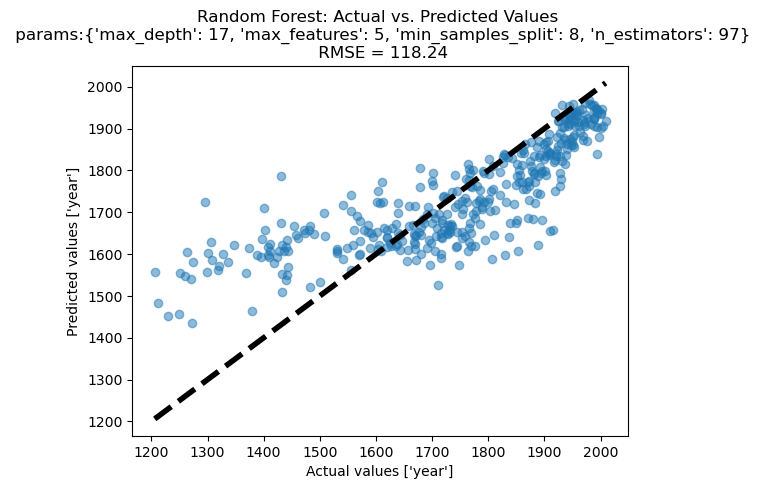

In [103]:
# generate the actual vs. predicted plot
from al_lib.helper_functions import plot_actual_vs_pred

# import the optimal model parameters
rf_results = pd.read_csv(rf_rscv_results_file)
# select the model parameters with the lowest RMSE
optimal_params_str_rf = rf_results.loc[rf_results["RMSE"].idxmin(), "params"]
optimal_params_rf = dict(eval(optimal_params_str_rf))

rf_opt = RandomForestRegressor(**optimal_params_rf)

y_pred_rf = rf_opt.fit(X_train, y_train).predict(X_test)

title_str = (
    f"Random Forest: Actual vs. Predicted Values \n params:"
    + optimal_params_str_rf
    + f"\n RMSE = {root_mean_squared_error(y_test, y_pred_rf):.2f}"
)

param_dict = {"title": title_str}
fig_path = f"{FIGURE_PATH}avp_rf.png"
fig, ax = plt.subplots(1, 1)
rf_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_rf, param_dict, fig_path)

# PLS Regressor - RSCV


In [104]:
from sklearn import cross_decomposition

pls = cross_decomposition.PLSRegression()
pls_rscv_results_file = f"{RESULTS_PATH}/pls_rscv_results.csv"

rscv(
    features=X,
    target=y,
    model=pls,
    param_distributions=pls_rscv_parameters,
    results_file=pls_rscv_results_file,
    random_state=random_state,
    NoTrials=NoTrials,
    nfolds=nfolds,
    n_jobs=n_jobs
)

2024-06-26 22:43:18 - INFO - STARTED the RandomizedSearchCV for PLSRegression() with 15 trials
2024-06-26 22:43:18 - INFO - Features: (1290, 410), Target: (1290,), Model: PLSRegression(), Param_distributions: {'n_components': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f733dd4b260>, 'scale': [True, False], 'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f733dd4a8a0>, 'tol': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f733dd4a120>, 'copy': [True]}, Results File: ../03_Modelling/03_1_rscv/rscv_results//pls_rscv_results.csv Random_state: RandomState(MT19937), NoTrials: 15, nfolds: 10, n_jobs: 30, Scoring: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')
2024-06-26 22:43:18 - INFO - Results file: ../03_Modelling/03_1_rscv/rscv_results//pls_rscv_results.csv
2024-06-26 22:43:18 - INFO - Trial: 0 out of 15
2024-06-26 22:43:27 - INFO - Trial: 1 out of 15


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 19, 'n_components': 20, 'scale': False, 'tol': np.float64(0.8244983741605915)}
Best score -103.37227075282567 for PLSRegression: -103.37227075282567
Best estimator for PLSRegression: PLSRegression(max_iter=19, n_components=20, scale=False,
              tol=np.float64(0.8244983741605915))


2024-06-26 22:43:36 - INFO - Trial: 2 out of 15


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 103, 'n_components': 19, 'scale': True, 'tol': np.float64(0.6379768052828697)}
Best score -104.84747327293567 for PLSRegression: -104.84747327293567
Best estimator for PLSRegression: PLSRegression(max_iter=103, n_components=19, tol=np.float64(0.6379768052828697))


2024-06-26 22:43:43 - INFO - Trial: 3 out of 15


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 159, 'n_components': 25, 'scale': True, 'tol': np.float64(0.3098688293753635)}
Best score -105.85882620781044 for PLSRegression: -105.85882620781044
Best estimator for PLSRegression: PLSRegression(max_iter=159, n_components=25, tol=np.float64(0.3098688293753635))


2024-06-26 22:43:52 - INFO - Trial: 4 out of 15


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 27, 'n_components': 16, 'scale': True, 'tol': np.float64(0.7884749072205139)}
Best score -104.34952645495396 for PLSRegression: -104.34952645495396
Best estimator for PLSRegression: PLSRegression(max_iter=27, n_components=16, tol=np.float64(0.7884749072205139))


2024-06-26 22:44:02 - INFO - Trial: 5 out of 15


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 158, 'n_components': 26, 'scale': True, 'tol': np.float64(0.9649399838947764)}
Best score -104.44339218682342 for PLSRegression: -104.44339218682342
Best estimator for PLSRegression: PLSRegression(max_iter=158, n_components=26, tol=np.float64(0.9649399838947764))


2024-06-26 22:44:11 - INFO - Trial: 6 out of 15


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 379, 'n_components': 25, 'scale': False, 'tol': np.float64(0.4462382206173284)}
Best score -103.13038164345228 for PLSRegression: -103.13038164345228
Best estimator for PLSRegression: PLSRegression(max_iter=379, n_components=25, scale=False,
              tol=np.float64(0.4462382206173284))


2024-06-26 22:44:18 - INFO - Trial: 7 out of 15


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 335, 'n_components': 11, 'scale': True, 'tol': np.float64(0.7535206902871966)}
Best score -104.37837573421066 for PLSRegression: -104.37837573421066
Best estimator for PLSRegression: PLSRegression(max_iter=335, n_components=11, tol=np.float64(0.7535206902871966))


2024-06-26 22:44:27 - INFO - Trial: 8 out of 15


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 459, 'n_components': 12, 'scale': False, 'tol': np.float64(0.3000640615051812)}
Best score -105.46259582139217 for PLSRegression: -105.46259582139217
Best estimator for PLSRegression: PLSRegression(max_iter=459, n_components=12, scale=False,
              tol=np.float64(0.3000640615051812))


2024-06-26 22:44:36 - INFO - Trial: 9 out of 15


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 274, 'n_components': 23, 'scale': False, 'tol': np.float64(0.47411406919077964)}
Best score -103.77060573718234 for PLSRegression: -103.77060573718234
Best estimator for PLSRegression: PLSRegression(max_iter=274, n_components=23, scale=False,
              tol=np.float64(0.47411406919077964))


2024-06-26 22:44:44 - INFO - Trial: 10 out of 15


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 148, 'n_components': 18, 'scale': True, 'tol': np.float64(0.6745616793485361)}
Best score -102.233985949735 for PLSRegression: -102.233985949735
Best estimator for PLSRegression: PLSRegression(max_iter=148, n_components=18, tol=np.float64(0.6745616793485361))


2024-06-26 22:44:52 - INFO - Trial: 11 out of 15


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 23, 'n_components': 21, 'scale': True, 'tol': np.float64(0.07355567806565752)}
Best score -103.98561187151611 for PLSRegression: -103.98561187151611
Best estimator for PLSRegression: PLSRegression(max_iter=23, n_components=21, tol=np.float64(0.07355567806565752))


2024-06-26 22:44:59 - INFO - Trial: 12 out of 15


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 118, 'n_components': 10, 'scale': True, 'tol': np.float64(0.6576858391981729)}
Best score -105.46499125750822 for PLSRegression: -105.46499125750822
Best estimator for PLSRegression: PLSRegression(max_iter=118, n_components=10, tol=np.float64(0.6576858391981729))


2024-06-26 22:45:07 - INFO - Trial: 13 out of 15


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 605, 'n_components': 19, 'scale': False, 'tol': np.float64(0.6692171411309823)}
Best score -103.68982955021787 for PLSRegression: -103.68982955021787
Best estimator for PLSRegression: PLSRegression(max_iter=605, n_components=19, scale=False,
              tol=np.float64(0.6692171411309823))


2024-06-26 22:45:15 - INFO - Trial: 14 out of 15


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 201, 'n_components': 15, 'scale': False, 'tol': np.float64(0.3938398365993853)}
Best score -105.11175098646429 for PLSRegression: -105.11175098646429
Best estimator for PLSRegression: PLSRegression(max_iter=201, n_components=15, scale=False,
              tol=np.float64(0.3938398365993853))


2024-06-26 22:45:24 - INFO - FINISHED the RandomizedSearchCV for PLSRegression() with 15 trials


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 348, 'n_components': 18, 'scale': True, 'tol': np.float64(0.2835476731792907)}
Best score -103.92326127556255 for PLSRegression: -103.92326127556255
Best estimator for PLSRegression: PLSRegression(max_iter=348, n_components=18, tol=np.float64(0.2835476731792907))


model        MAE        RMSE  \
0   PLSRegression()   83.78965  110.821694   
1   PLSRegression()  96.503502  126.347752   
2   PLSRegression()  83.742642  112.201793   
3   PLSRegression()  95.676203  128.399438   
4   PLSRegression()  81.259542  109.807382   
5   PLSRegression()  83.651861   113.18786   
6   PLSRegression()  82.234419  109.890734   
7   PLSRegression()  81.673417  108.319987   
8   PLSRegression()  84.325027  110.781116   
9   PLSRegression()  94.900612   124.81318   
10  PLSRegression()  83.106406    110.7268   
11  PLSRegression()   92.30197  121.039639   
12  PLSRegression()  83.119733  111.073441   
13  PLSRegression()   82.82262  109.296025   
14  PLSRegression()  83.790397  111.160225   

                                               params  
0   {'copy': True, 'max_iter': 19, 'n_components':...  
1   {'copy': True, 'max_iter': 103, 'n_components'...  
2   {'copy': True, 'max_iter': 159, 'n_components'...  
3   {'copy': True, 'max_iter': 27, 'n_components':...  
4   {'copy': True, 'max_iter': 158, 'n_components'...  
5   {'copy': True, 'max_iter': 379, 'n_components'...  
6   {'copy': True, 'max_iter': 335, 'n_components'...  
7   {'copy': True, 'max_iter': 459, 'n_components'...  
8   {'copy': True, 'max_iter': 274, 'n_components'...  
9   {'copy': True, 'max_iter': 148, 'n_components'...  
10  {'copy': True, 'max_iter': 23, 'n_components':...  
11  {'copy': True, 'max_iter': 118, 'n_components'...  
12  {'copy': True, 'max_iter': 605, 'n_components'...  
13  {'copy': True, 'max_iter': 201, 'n_components'...  
14  {'copy': True, 'max_iter': 348, 'n_components'...

In [105]:
# generate the actual vs. predicted plot
from al_lib.helper_functions import plot_actual_vs_pred

# import the optimal model parameters
pls_results = pd.read_csv(pls_rscv_results_file)
# select the model parameters with the lowest RMSE
optimal_params_str_pls = pls_results.loc[pls_results["RMSE"].idxmin(), "params"]
optimal_params_pls = dict(eval(optimal_params_str_pls))
# fit the data with the optimal model parameters
pls_opt = cross_decomposition.PLSRegression(**optimal_params_pls)

y_pred_pls = pls_opt.fit(X_train, y_train).predict(X_test)

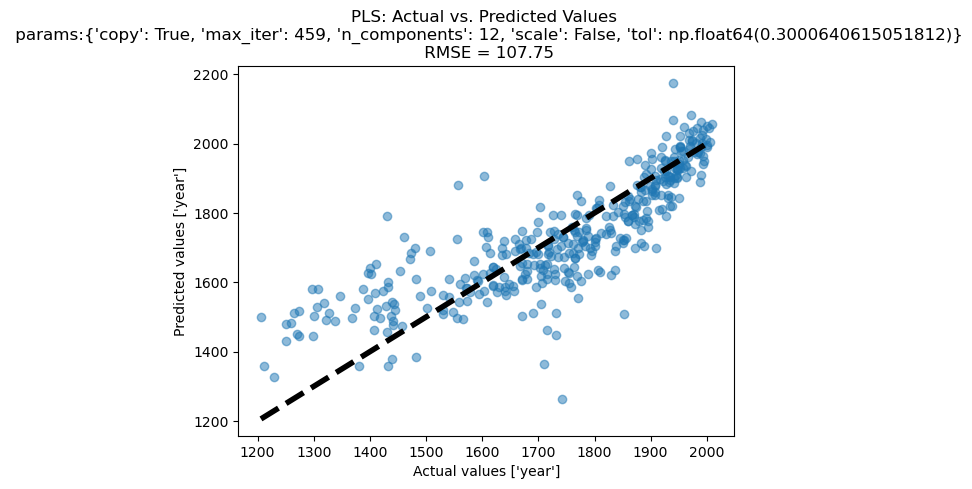

In [106]:
# plot
title_str = (
    f"PLS: Actual vs. Predicted Values \n params:"
    + optimal_params_str_pls
    + f"\n RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_pls)):.2f}"
)

param_dict = {"title": title_str}
fig_path = (f"{FIGURE_PATH}/avp_pls.png")

fig, ax = plt.subplots(1, 1)
pls_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_pls, param_dict, fig_path)

In [29]:
testing

False

# KKR Regressor - RSCV

In [26]:
from sklearn.kernel_ridge import KernelRidge as KRR

krr = KRR()
krr_rscv_results_file = f"{RESULTS_PATH}/krr_rscv_results.csv"



rscv(
    features=X,
    target=y,
    model=krr,
    param_distributions=krr_rscv_parameters,
    results_file=krr_rscv_results_file,
    random_state=random_state,
    NoTrials=NoTrials,
    nfolds=nfolds,
    n_jobs=n_jobs
)

2024-06-28 12:14:03 - INFO - STARTED the RandomizedSearchCV for KernelRidge() with 15 trials
2024-06-28 12:14:03 - INFO - Features: (1290, 410), Target: (1290,), Model: KernelRidge(), Param_distributions: {'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f5ce0616a50>, 'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f5ce0616750>, 'kernel': ['rbf', 'linear', 'poly', 'polynomial', 'chi2']}, Results File: ../03_Modelling/03_1_rscv/rscv_results//krr_rscv_results.csv Random_state: RandomState(MT19937), NoTrials: 15, nfolds: 10, n_jobs: 30, Scoring: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')
2024-06-28 12:14:03 - INFO - Results file: ../03_Modelling/03_1_rscv/rscv_results//krr_rscv_results.csv
2024-06-28 12:14:03 - INFO - Trial: 0 out of 15
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed o

Best hyperparameters for KernelRidge: {'alpha': np.float64(0.00012266195574568952), 'gamma': np.float64(260701.8841753726), 'kernel': 'poly'}
Best score -109.17792349137748 for KernelRidge: -109.17792349137748
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.00012266195574568952),
            gamma=np.float64(260701.8841753726), kernel='poly')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1052: UserWarning: One or more of the test scores are non-finite: [ -165.89568213 -1753.5213765   -149.65623508 -1702.90439078
  -170.63798525            nan  -113.44841858 -1753.53289824
 -1742.47520201  -201.80945826]
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_v

Best hyperparameters for KernelRidge: {'alpha': np.float64(6.4852736183937824e-06), 'gamma': np.float64(313048.8459074711), 'kernel': 'rbf'}
Best score -113.44841858491534 for KernelRidge: -113.44841858491534
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(6.4852736183937824e-06),
            gamma=np.float64(313048.8459074711), kernel='rbf')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1052: UserWarning: One or more of the test scores are non-finite: [ -411.70786859            nan -1731.52742873  -129.85010413
  -193.92676285  -193.90198402 -1753.60474735  -194.08543146
  -184.09204183            nan]
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_v

Best hyperparameters for KernelRidge: {'alpha': np.float64(1.3165102328183171e-06), 'gamma': np.float64(440406.3118429541), 'kernel': 'polynomial'}
Best score -129.8501041335839 for KernelRidge: -129.8501041335839
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(1.3165102328183171e-06),
            gamma=np.float64(440406.3118429541), kernel='polynomial')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1052: UserWarning: One or more of the test scores are non-finite: [ -125.23045504            nan   -97.78830887 -1500.44567257
 -1750.1998112  -1009.52500733 -1753.58298983 -1160.87840509
  -228.92285009  -336.86525521]
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_v

Best hyperparameters for KernelRidge: {'alpha': np.float64(2.0373459543878623e-06), 'gamma': np.float64(3639.8220246628343), 'kernel': 'poly'}
Best score -97.78830886696619 for KernelRidge: -97.78830886696619
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(2.0373459543878623e-06),
            gamma=np.float64(3639.8220246628343), kernel='poly')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1052: UserWarning: One or more of the test scores are non-finite: [  -94.28938226  -101.8592959  -1753.52958036            nan
 -1751.02868458 -1750.15180129  -184.36435179  -193.64046069
  -325.37751105            nan]
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_v

Best hyperparameters for KernelRidge: {'alpha': np.float64(0.0006739020867475914), 'gamma': np.float64(97508.38435276879), 'kernel': 'polynomial'}
Best score -94.28938225598637 for KernelRidge: -94.28938225598637
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.0006739020867475914),
            gamma=np.float64(97508.38435276879), kernel='polynomial')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1052: UserWarning: One or more of the test scores are non-finite: [           nan   -97.54991238 -1702.18950424  -192.22601375
 -1673.04506649  -547.88779947 -1753.64733802   -96.46643645
 -1750.65356909  -124.69465143]
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_v

Best hyperparameters for KernelRidge: {'alpha': np.float64(5.542949206436735e-06), 'gamma': np.float64(6475.28663572562), 'kernel': 'poly'}
Best score -96.4664364458043 for KernelRidge: -96.4664364458043
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(5.542949206436735e-06),
            gamma=np.float64(6475.28663572562), kernel='poly')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1052: UserWarning: One or more of the test scores are non-finite: [ -193.80483388  -145.67479131            nan -1742.88255396
  -251.96471288 -1751.51920892  -196.2491238   -153.07488994
 -1751.53235118  -106.5481428 ]
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_v

Best hyperparameters for KernelRidge: {'alpha': np.float64(0.0006799686272033916), 'gamma': np.float64(979.7270038167078), 'kernel': 'polynomial'}
Best score -106.54814279772181 for KernelRidge: -106.54814279772181
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.0006799686272033916),
            gamma=np.float64(979.7270038167078), kernel='polynomial')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1052: UserWarning: One or more of the test scores are non-finite: [ -381.72641712            nan -1698.56012181  -196.64605799
            nan -1631.10802439  -179.61757543  -751.9274985
 -1745.93819371 -1748.26719835]
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_va

Best hyperparameters for KernelRidge: {'alpha': np.float64(1.1779550577407433e-06), 'gamma': np.float64(4021.1439648254), 'kernel': 'linear'}
Best score -179.617575426709 for KernelRidge: -179.617575426709
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(1.1779550577407433e-06),
            gamma=np.float64(4021.1439648254))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1052: UserWarning: One or more of the test scores are non-finite: [           nan  -695.16692782  -192.71861347  -281.1290951
 -1753.58129159 -1748.94483463  -193.74240333   -98.5696833
 -1455.40082702            nan]
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_val

Best hyperparameters for KernelRidge: {'alpha': np.float64(0.00030005959000051154), 'gamma': np.float64(18388.00783301206), 'kernel': 'poly'}
Best score -98.56968330385482 for KernelRidge: -98.56968330385482
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.00030005959000051154),
            gamma=np.float64(18388.00783301206), kernel='poly')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1052: UserWarning: One or more of the test scores are non-finite: [ -100.82800908  -181.18122231  -521.33766547  -205.84173941
            nan            nan  -193.19541456            nan
 -1746.59635048  -198.62628686]
  warnings.warn(
2024-06-28 12:14:34 - INFO - Trial: 10 out of 15


Best hyperparameters for KernelRidge: {'alpha': np.float64(2.337272339796615e-05), 'gamma': np.float64(3046.7023258849235), 'kernel': 'polynomial'}
Best score -100.82800908126455 for KernelRidge: -100.82800908126455
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(2.337272339796615e-05),
            gamma=np.float64(3046.7023258849235), kernel='polynomial')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fhwn.ac.at/202375

Best hyperparameters for KernelRidge: {'alpha': np.float64(6.708737523653618e-06), 'gamma': np.float64(9.669030449905236), 'kernel': 'rbf'}
Best score -108.87023169386839 for KernelRidge: -108.87023169386839
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(6.708737523653618e-06),
            gamma=np.float64(9.669030449905236), kernel='rbf')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1052: UserWarning: One or more of the test scores are non-finite: [           nan -1665.41571736  -138.72886933            nan
            nan -1749.08495458  -141.12960376  -137.15471393
  -101.65765014  -193.86601165]
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_v

Best hyperparameters for KernelRidge: {'alpha': np.float64(2.6422333010556642e-05), 'gamma': np.float64(3259.2678665380527), 'kernel': 'poly'}
Best score -101.65765013645719 for KernelRidge: -101.65765013645719
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(2.6422333010556642e-05),
            gamma=np.float64(3259.2678665380527), kernel='poly')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1052: UserWarning: One or more of the test scores are non-finite: [-1744.09668546  -175.1386918   -145.17264442  -259.09557532
            nan -1518.07490495  -193.3239027  -1731.79501026
  -195.41270996  -183.71577825]
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_v

Best hyperparameters for KernelRidge: {'alpha': np.float64(5.033847606301954), 'gamma': np.float64(197825.331784743), 'kernel': 'poly'}
Best score -145.17264442207096 for KernelRidge: -145.17264442207096
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(5.033847606301954),
            gamma=np.float64(197825.331784743), kernel='poly')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1052: UserWarning: One or more of the test scores are non-finite: [-1282.55148349  -116.65823555            nan  -116.77435357
 -1753.53527309            nan            nan  -107.56801376
  -192.64509241 -1748.60240989]
  warnings.warn(
2024-06-28 12:14:45 - INFO - Trial: 14 out of 15


Best hyperparameters for KernelRidge: {'alpha': np.float64(2.376548184729366e-06), 'gamma': np.float64(25227.21308178181), 'kernel': 'polynomial'}
Best score -107.5680137613042 for KernelRidge: -107.5680137613042
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(2.376548184729366e-06),
            gamma=np.float64(25227.21308178181), kernel='polynomial')


2024-06-28 12:14:48 - INFO - FINISHED the RandomizedSearchCV for KernelRidge() with 15 trials


Best hyperparameters for KernelRidge: {'alpha': np.float64(0.8288727950292395), 'gamma': np.float64(49943.93401040341), 'kernel': 'poly'}
Best score -140.64951949543476 for KernelRidge: -140.64951949543476
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.8288727950292395),
            gamma=np.float64(49943.93401040341), kernel='poly')


model         MAE        RMSE  \
0   KernelRidge()   97.423799   131.13687   
1   KernelRidge()  104.844245  140.502023   
2   KernelRidge()    90.84793  114.655628   
3   KernelRidge()   82.187397  108.316078   
4   KernelRidge()   79.719919  105.790526   
5   KernelRidge()   93.637346  119.885872   
6   KernelRidge()  160.557854  204.262821   
7   KernelRidge()   79.864775  107.314967   
8   KernelRidge()   80.272975  106.180407   
9   KernelRidge()   97.219574  122.787873   
10  KernelRidge()   82.322825  108.924817   
11  KernelRidge()  142.335989  172.958137   
12  KernelRidge()  106.860861   133.84589   
13  KernelRidge()  135.022632  162.714893   
14  KernelRidge()   98.224178  137.628059   

                                               params  
0   {'alpha': 0.00012266195574568952, 'gamma': 260...  
1   {'alpha': 6.4852736183937824e-06, 'gamma': 313...  
2   {'alpha': 1.3165102328183171e-06, 'gamma': 440...  
3   {'alpha': 2.0373459543878623e-06, 'gamma': 363...  
4   {'alpha': 0.0006739020867475914, 'gamma': 9750...  
5   {'alpha': 5.542949206436735e-06, 'gamma': 6475...  
6   {'alpha': 0.0006799686272033916, 'gamma': 979....  
7   {'alpha': 1.1779550577407433e-06, 'gamma': 402...  
8   {'alpha': 0.00030005959000051154, 'gamma': 183...  
9   {'alpha': 2.337272339796615e-05, 'gamma': 3046...  
10  {'alpha': 6.708737523653618e-06, 'gamma': 9.66...  
11  {'alpha': 2.6422333010556642e-05, 'gamma': 325...  
12  {'alpha': 5.033847606301954, 'gamma': 197825.3...  
13  {'alpha': 2.376548184729366e-06, 'gamma': 2522...  
14  {'alpha': 0.8288727950292395, 'gamma': 49943.9...

In [108]:
# generate the actual vs. predicted plot

# import the optimal model parameters
krr_results = pd.read_csv(krr_rscv_results_file)

# select the model parameters with the lowest RMSE
optimal_params_str_krr = krr_results.loc[krr_results["RMSE"].idxmin(), "params"]
optimal_params_krr = dict(eval(optimal_params_str_krr))
krr_opt = KRR(**optimal_params_krr)

y_pred_krr = krr_opt.fit(X_train, y_train).predict(X_test)

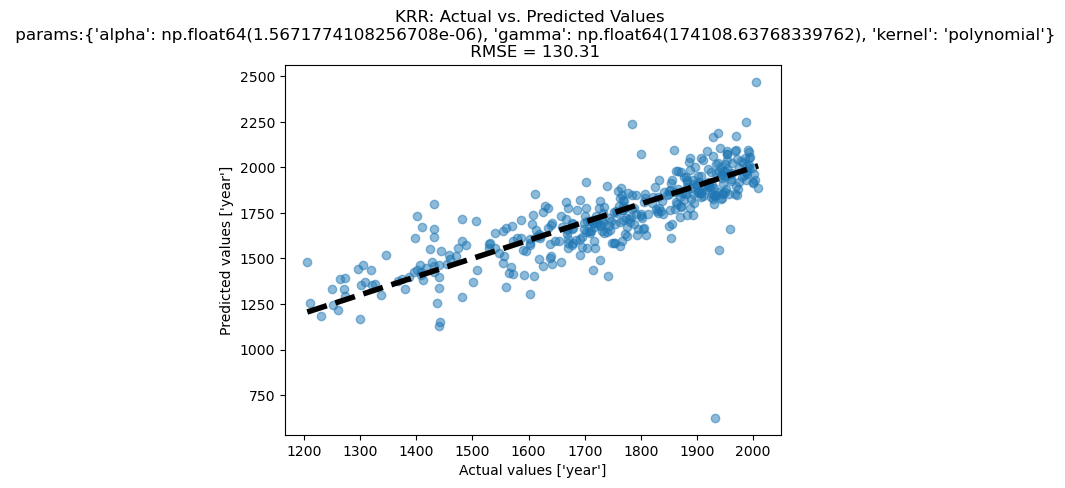

In [109]:
# plot
from al_lib.helper_functions import plot_actual_vs_pred

# break the optimal_params_str_krr string into more lines

title_str = (
    f"KRR: Actual vs. Predicted Values \n params:"
    + optimal_params_str_krr
    + f"\n RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_krr)):.2f}"
)

param_dict = {"title": title_str}
fig_path_krr = (f"{FIGURE_PATH}/avp_krr.png")

fig, ax = plt.subplots(1, 1)
krr_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_krr, param_dict, fig_path_krr)

# MLP Regressor - RSCV

In [110]:
# import mlp
from sklearn.neural_network import MLPRegressor as MLP



mlp = MLP()
mlp_rscv_results_file = f"{RESULTS_PATH}/mlp_rscv_results.csv"

rscv_mpl = rscv(
    features=X,
    target=y,
    model=mlp,
    param_distributions=mlp_rscv_parameters,
    results_file=mlp_rscv_results_file,
    random_state=random_state,
    NoTrials=NoTrials,
    nfolds=nfolds,
    n_jobs=n_jobs
)

2024-06-26 22:46:05 - INFO - STARTED the RandomizedSearchCV for MLPRegressor() with 15 trials
2024-06-26 22:46:05 - INFO - Features: (1290, 410), Target: (1290,), Model: MLPRegressor(), Param_distributions: {'hidden_layer_sizes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f733dd48c20>, 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'], 'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f733dd48830>, 'early_stopping': [True, False], 'validation_fraction': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f733dd485f0>}, Results File: ../03_Modelling/03_1_rscv/rscv_results//mlp_rscv_results.csv Random_state: RandomState(MT19937), NoTrials: 15, nfolds: 10, n_jobs: 30, Scoring: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')
2024-06-26 22:46:05 - INFO - Results file: ../03_Modelling/03_1_rscv/rscv_results//mlp_rscv_results.csv
2024-06-26 22:

Best hyperparameters for MLPRegressor: {'activation': 'tanh', 'alpha': np.float64(0.07498858932989942), 'early_stopping': False, 'hidden_layer_sizes': 99, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.12037786718621497)}
Best score -156.63914912448524 for MLPRegressor: -156.63914912448524
Best estimator for MLPRegressor: MLPRegressor(activation='tanh', alpha=np.float64(0.07498858932989942),
             hidden_layer_sizes=99, solver='lbfgs',
             validation_fraction=np.float64(0.12037786718621497))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/home/fhwn.ac.at

Best hyperparameters for MLPRegressor: {'activation': 'identity', 'alpha': np.float64(0.03428059716119121), 'early_stopping': False, 'hidden_layer_sizes': 111, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.1873938658666363)}
Best score -136.973581892778 for MLPRegressor: -136.973581892778
Best estimator for MLPRegressor: MLPRegressor(activation='identity', alpha=np.float64(0.03428059716119121),
             hidden_layer_sizes=111, solver='lbfgs',
             validation_fraction=np.float64(0.1873938658666363))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered

Best hyperparameters for MLPRegressor: {'activation': 'relu', 'alpha': np.float64(0.0035299834571728248), 'early_stopping': True, 'hidden_layer_sizes': 115, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.19439135776246616)}
Best score -151.06458162809162 for MLPRegressor: -151.06458162809162
Best estimator for MLPRegressor: MLPRegressor(alpha=np.float64(0.0035299834571728248), early_stopping=True,
             hidden_layer_sizes=115, solver='lbfgs',
             validation_fraction=np.float64(0.19439135776246616))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

Best hyperparameters for MLPRegressor: {'activation': 'identity', 'alpha': np.float64(0.08116248857742038), 'early_stopping': True, 'hidden_layer_sizes': 83, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.17000874906802677)}
Best score -145.26550760845709 for MLPRegressor: -145.26550760845709
Best estimator for MLPRegressor: MLPRegressor(activation='identity', alpha=np.float64(0.08116248857742038),
             early_stopping=True, hidden_layer_sizes=83, solver='lbfgs',
             validation_fraction=np.float64(0.17000874906802677))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: Ru

Best hyperparameters for MLPRegressor: {'activation': 'tanh', 'alpha': np.float64(0.015113245084480986), 'early_stopping': True, 'hidden_layer_sizes': 195, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.12423883515420468)}
Best score -154.1372362706791 for MLPRegressor: -154.1372362706791
Best estimator for MLPRegressor: MLPRegressor(activation='tanh', alpha=np.float64(0.015113245084480986),
             early_stopping=True, hidden_layer_sizes=195, solver='lbfgs',
             validation_fraction=np.float64(0.12423883515420468))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

Best hyperparameters for MLPRegressor: {'activation': 'identity', 'alpha': np.float64(0.05793021836546795), 'early_stopping': True, 'hidden_layer_sizes': 184, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.1733348638069504)}
Best score -141.72629824342727 for MLPRegressor: -141.72629824342727
Best estimator for MLPRegressor: MLPRegressor(activation='identity', alpha=np.float64(0.05793021836546795),
             early_stopping=True, hidden_layer_sizes=184, solver='lbfgs',
             validation_fraction=np.float64(0.1733348638069504))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reach

Best hyperparameters for MLPRegressor: {'activation': 'identity', 'alpha': np.float64(0.08765176844277826), 'early_stopping': False, 'hidden_layer_sizes': 85, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.19486665497633043)}
Best score -146.82562897255963 for MLPRegressor: -146.82562897255963
Best estimator for MLPRegressor: MLPRegressor(activation='identity', alpha=np.float64(0.08765176844277826),
             hidden_layer_sizes=85, solver='lbfgs',
             validation_fraction=np.float64(0.19486665497633043))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

Best hyperparameters for MLPRegressor: {'activation': 'tanh', 'alpha': np.float64(0.032497474534495724), 'early_stopping': False, 'hidden_layer_sizes': 108, 'solver': 'sgd', 'validation_fraction': np.float64(0.19138843610022832)}
Best score -192.92740393800116 for MLPRegressor: -192.92740393800116
Best estimator for MLPRegressor: MLPRegressor(activation='tanh', alpha=np.float64(0.032497474534495724),
             hidden_layer_sizes=108, solver='sgd',
             validation_fraction=np.float64(0.19138843610022832))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

Best hyperparameters for MLPRegressor: {'activation': 'identity', 'alpha': np.float64(0.006729195631960594), 'early_stopping': True, 'hidden_layer_sizes': 177, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.14447936492978736)}
Best score -136.83141281112663 for MLPRegressor: -136.83141281112663
Best estimator for MLPRegressor: MLPRegressor(activation='identity', alpha=np.float64(0.006729195631960594),
             early_stopping=True, hidden_layer_sizes=177, solver='lbfgs',
             validation_fraction=np.float64(0.14447936492978736))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.

Best hyperparameters for MLPRegressor: {'activation': 'identity', 'alpha': np.float64(0.05374660041871267), 'early_stopping': False, 'hidden_layer_sizes': 96, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.14998056247689318)}
Best score -147.75837616176273 for MLPRegressor: -147.75837616176273
Best estimator for MLPRegressor: MLPRegressor(activation='identity', alpha=np.float64(0.05374660041871267),
             hidden_layer_sizes=96, solver='lbfgs',
             validation_fraction=np.float64(0.14998056247689318))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or sc

Best hyperparameters for MLPRegressor: {'activation': 'identity', 'alpha': np.float64(0.07501219020497261), 'early_stopping': False, 'hidden_layer_sizes': 129, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.12236742943101779)}
Best score -143.05311616045987 for MLPRegressor: -143.05311616045987
Best estimator for MLPRegressor: MLPRegressor(activation='identity', alpha=np.float64(0.07501219020497261),
             hidden_layer_sizes=129, solver='lbfgs',
             validation_fraction=np.float64(0.12236742943101779))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reach

Best hyperparameters for MLPRegressor: {'activation': 'identity', 'alpha': np.float64(0.06654525942436432), 'early_stopping': False, 'hidden_layer_sizes': 192, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.1459295261332191)}
Best score -143.44452348566173 for MLPRegressor: -143.44452348566173
Best estimator for MLPRegressor: MLPRegressor(activation='identity', alpha=np.float64(0.06654525942436432),
             hidden_layer_sizes=192, solver='lbfgs',
             validation_fraction=np.float64(0.1459295261332191))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/t

Best hyperparameters for MLPRegressor: {'activation': 'identity', 'alpha': np.float64(0.03141693946792441), 'early_stopping': True, 'hidden_layer_sizes': 58, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.13378391210248225)}
Best score -141.7663200129019 for MLPRegressor: -141.7663200129019
Best estimator for MLPRegressor: MLPRegressor(activation='identity', alpha=np.float64(0.03141693946792441),
             early_stopping=True, hidden_layer_sizes=58, solver='lbfgs',
             validation_fraction=np.float64(0.13378391210248225))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.

Best hyperparameters for MLPRegressor: {'activation': 'identity', 'alpha': np.float64(0.09080632152040273), 'early_stopping': True, 'hidden_layer_sizes': 189, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.17798719718316183)}
Best score -143.881002486139 for MLPRegressor: -143.881002486139
Best estimator for MLPRegressor: MLPRegressor(activation='identity', alpha=np.float64(0.09080632152040273),
             early_stopping=True, hidden_layer_sizes=189, solver='lbfgs',
             validation_fraction=np.float64(0.17798719718316183))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

Best hyperparameters for MLPRegressor: {'activation': 'identity', 'alpha': np.float64(0.036376627886480196), 'early_stopping': True, 'hidden_layer_sizes': 185, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.17392699938367348)}
Best score -143.2706052819538 for MLPRegressor: -143.2706052819538
Best estimator for MLPRegressor: MLPRegressor(activation='identity', alpha=np.float64(0.036376627886480196),
             early_stopping=True, hidden_layer_sizes=185, solver='lbfgs',
             validation_fraction=np.float64(0.17392699938367348))


In [111]:
# generate the actual vs. predicted plot

# import the optimal model parameters
mlp_results = pd.read_csv(mlp_rscv_results_file)

# select the (optimal) model parameters with the lowest RMSE
optimal_params_str_mlp = mlp_results.loc[mlp_results["RMSE"].idxmin(), "params"]
optimal_params_mlp = dict(eval(optimal_params_str_mlp))

# fit the data with the optimal model parameters
mlp_opt = MLP(**optimal_params_mlp)

y_pred_mlp = mlp_opt.fit(X_train, y_train).predict(X_test)

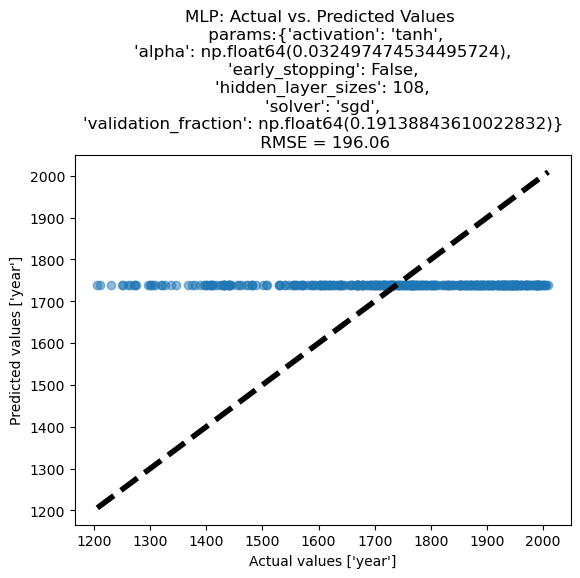

In [112]:
# plot
from al_lib.helper_functions import plot_actual_vs_pred

# break the optimal_params_str_mlp string into more lines
optimal_params_str_mlp_break = optimal_params_str_mlp.replace(", ", ",\n")

title_str = (
    f"MLP: Actual vs. Predicted Values \n params:"
    + optimal_params_str_mlp_break
    + f"\n RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_mlp)):.2f}"
)

param_dict = {"title": title_str}
fig_path_mlp = (f"{FIGURE_PATH}/avp_mlp.png")

fig, ax = plt.subplots(1, 1)
mlp_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_mlp, param_dict, fig_path_mlp)

In [26]:
# import xgboost
import xgboost as xgb
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb_rscv_results_file = f"{RESULTS_PATH}/xgb_rscv_results.csv"

rscv_xgb = rscv(
    features=X,
    target=y,
    model=xgb,
    param_distributions=xgb_rscv_parameters,
    results_file=xgb_rscv_results_file,
    random_state=random_state,
    NoTrials=NoTrials,
    nfolds=nfolds,
    n_jobs=n_jobs
)

2024-06-27 01:52:54 - INFO - STARTED the RandomizedSearchCV for XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) with 15 trials
2024-06-27 01:52:54 - INFO - Features: (1290, 410), Target: (1290,), Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, c

Best hyperparameters for XGBRegressor: {'colsample_bytree': np.float64(0.8689748086307219), 'gamma': np.float64(0.40429170642122425), 'learning_rate': np.float64(0.08518474873523173), 'max_depth': 6, 'n_estimators': 78, 'reg_alpha': np.float64(0.4610145934920938), 'reg_lambda': np.float64(0.42189535403823053), 'subsample': np.float64(0.7032258382098104)}
Best score -97.30671706000466 for XGBRegressor: -97.30671706000466
Best estimator for XGBRegressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.8689748086307219), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(0.40429170642122425), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.08518474873523173), max_bin=None,
             max_cat_

/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-06-27 02:11:26 - INFO - Trial: 2 out of 15


Best hyperparameters for XGBRegressor: {'colsample_bytree': np.float64(0.7990128753676852), 'gamma': np.float64(0.06058893566562956), 'learning_rate': np.float64(0.10090514106990496), 'max_depth': 5, 'n_estimators': 97, 'reg_alpha': np.float64(0.06592779409230998), 'reg_lambda': np.float64(0.2415191005182024), 'subsample': np.float64(0.6909161749364048)}
Best score -97.19920799276397 for XGBRegressor: -97.19920799276397
Best estimator for XGBRegressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.7990128753676852), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(0.06058893566562956), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.10090514106990496), max_bin=None,
             max_cat_

2024-06-27 02:18:18 - INFO - Trial: 3 out of 15


Best hyperparameters for XGBRegressor: {'colsample_bytree': np.float64(0.5219302406680213), 'gamma': np.float64(0.04870553063965738), 'learning_rate': np.float64(0.04193035098502818), 'max_depth': 9, 'n_estimators': 98, 'reg_alpha': np.float64(0.0330639174415126), 'reg_lambda': np.float64(0.008390010219938626), 'subsample': np.float64(0.5458065019400444)}
Best score -96.05160632532714 for XGBRegressor: -96.05160632532714
Best estimator for XGBRegressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.5219302406680213), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(0.04870553063965738), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.04193035098502818), max_bin=None,
             max_cat

/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [1]:
# generate the actual vs. predicted plot

# import the optimal model parameters
xgb_results = pd.read_csv(xgb_rscv_results_file)

# round the results to 4 decimal places
xgb_results = xgb_results.round(4)

# select the model parameters with the lowest RMSE
optimal_params_str_xgb = xgb_results.loc[xgb_results["RMSE"].idxmin(), "params"]
optimal_params_xgb = dict(eval(optimal_params_str_xgb))

# fit the data with the optimal model parameters
xgb_opt = XGBRegressor(**optimal_params_xgb)

y_pred_xgb = xgb_opt.fit(X_train, y_train).predict(X_test)

NameError: name 'pd' is not defined

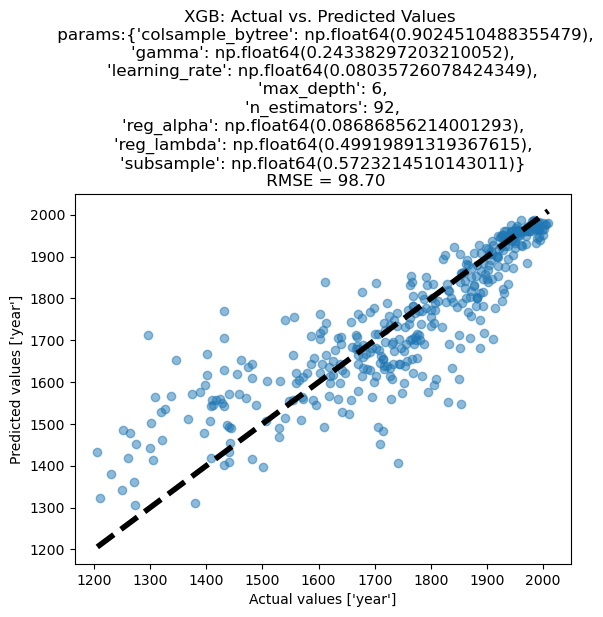

In [115]:
# plot
from al_lib.helper_functions import plot_actual_vs_pred

# break the optimal_params_str_ string into more lines
optimal_params_str_xgb_break = optimal_params_str_xgb.replace(", ", ",\n")

title_str = (
    f"XGB: Actual vs. Predicted Values \n params:"
    + optimal_params_str_xgb_break
    + f"\n RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}"
)

param_dict = {"title": title_str}
fig_path = (f"{FIGURE_PATH}/avp_xgb.png")

fig, ax = plt.subplots(1, 1)
xgb_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_xgb, param_dict, fig_path)

# HGB

In [25]:
# HGB
from sklearn.ensemble import HistGradientBoostingRegressor as HGB

hbg = HGB()
hgb_rscv_results_file = f"{RESULTS_PATH}/hgb_rscv_results.csv"

rscv_hgb = rscv(
    features=X,
    target=y,
    model=hbg,
    param_distributions=hgb_rscv_parameters,
    results_file=hgb_rscv_results_file,
    random_state=random_state,
    NoTrials=NoTrials,
    nfolds=nfolds,
    n_jobs=n_jobs
)

2024-06-30 14:59:19 - INFO - STARTED the RandomizedSearchCV for HistGradientBoostingRegressor() with 15 trials
2024-06-30 14:59:19 - INFO - Features: (1290, 410), Target: (1290,), Model: HistGradientBoostingRegressor(), Param_distributions: {'loss': ['squared_error'], 'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f495ce696d0>, 'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f495ce6a090>, 'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f495ce6a570>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f495ce6a5a0>}, Results File: ../03_Modelling/03_1_rscv/rscv_results//hgb_rscv_results.csv Random_state: RandomState(MT19937), NoTrials: 15, nfolds: 10, n_jobs: 30, Scoring: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')
2024-06-30 14:59:19 - INFO - Results file: ../03_Modelling/03_1_rscv/rscv_results//hgb_rsc

In [1]:
# generate the actual vs. predicted plot
hgb_results = pd.read_csv(hgb_rscv_results_file)

# select the model parameters with the lowest RMSE
# select the model parameters with the lowest RMSE
optimal_params_str_hgb = hgb_results.loc[hgb_results["RMSE"].idxmin(), "params"]
optimal_params_hgb = dict(eval(optimal_params_str_hgb))

# fit the data with the optimal model parameters
hgb_opt = HGB(**optimal_params_hgb)

y_pred_hgb = hgb_opt.fit(X_train, y_train).predict(X_test)

NameError: name 'pd' is not defined

In [ ]:
# plot
from al_lib.helper_functions import plot_actual_vs_pred

# break the optimal_params_str_ string into more lines
optimal_params_str_hgb_break = optimal_params_str_hgb.replace(", ", ",\n")


title_str = (
    f"HGB: Actual vs. Predicted Values \n params:"
    + optimal_params_str_hgb_break
    + f"\n RMSE = {root_mean_squared_error(y_test, y_pred_hgb):.2f}"
)
fig_path = (f"{FIGURE_PATH}/avp_xgb.png")
param_dict = {"title": title_str}

fig, ax = plt.subplots(1, 1)
xgb_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_xgb, param_dict, fig_path)

# Quality Control

In this section the goal is to document the packages which where used during the execution of this notebook

In [ ]:
## Package informations
from sklearn import show_versions

show_versions()

In [ ]:
import subprocess
import os
import datetime

# Add data/time information
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")

# Create the output name from the notebookname

output_name = f"{notebook_name.split('.')[0]}_{date}.html"


# Function to convert the notebook to HTML
def convert_notebook_to_html(notebook_name, output_name):
    # Use subprocess to call the jupyter nbconvert command
    subprocess.call(["jupyter", "nbconvert", "--to", "html", notebook_name])
    # Rename the output file
    os.rename(notebook_name.split(".")[0] + ".html", output_name)


# Wait for a short period to ensure all cells have finished executing
time.sleep(5)  # Adjust the sleep duration as needed

# Convert the notebook to HTML
convert_notebook_to_html(notebook_name, output_name)